In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
input_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials'
output_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials/Support Vector Machine'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
mice = ['2P05', '2P06', '2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

48

In [52]:
session_names = []
accuracies = []

for session in [sessions[10]]:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    # Try a SVM on single session
    svm_category = np.array(cells['category'])
    svm_binary = np.array(cells['binary'])
    svm_modality = np.array(cells['modality'])
    svm_session = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    svm_session = np.array(svm_session)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_modality, test_size=0.3,random_state=109) # 70% training and 30% test

    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_category, test_size=0.3,random_state=109) # 70% training and 30% test

    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_binary, test_size=0.3,random_state=109) # 70% training and 30% test

    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
cols = ['session', 'classification', 'accuracy']
svm_accuracy = pd.DataFrame(accuracies, columns=cols)
#svm_accuracy.to_csv(os.path.join(output_path, 'svm_accuracies.csv'))

processing:  dF_F0_SHORT_2P07_Ses01.csv
2P07_Ses01
Accuracy modality: 0.8636363636363636
Accuracy category: 0.8257575757575758
Accuracy binary: 0.9015151515151515


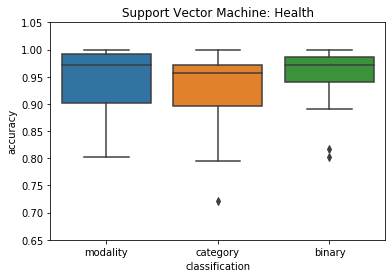

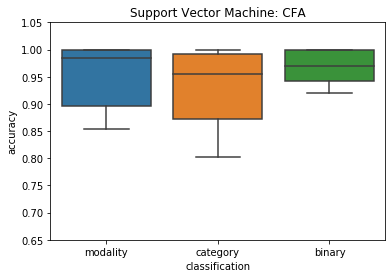

In [21]:
import seaborn as sns

health = svm_accuracy[svm_accuracy['session'].str.contains('Ses')]
cfa = svm_accuracy[svm_accuracy['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Support Vector Machine: Health')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'svm_health.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Support Vector Machine: CFA')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'svm_cfa.png'),bbox_inches='tight')
plt.show()


In [66]:
# TEST WHETHER SVM STILL DOES WELL IF ORDER OF TRIALS HAS BEEN SHUFFLED AFTER TRAINING 
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    
    # Try a SVM on single session
    svm_category = np.array(cells['category'])
    svm_binary = np.array(cells['binary'])
    svm_modality = np.array(cells['modality'])
    svm_session = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    svm_session = np.array(svm_session)
    
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_modality, test_size=0.3,random_state=109) # 70% training and 30% test

    # clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    # Train the model using the training sets
    clf.fit(X_train, y_train)
    
    # shuffle order of rows in test set
    df = pd.DataFrame(X_test, columns = cell_ids[:-1])
    df['modality'] = y_test
    df = df.sample(frac = 1)
    y_test = np.array(df['modality'])
    X_test = np.array(df.drop(['modality'], axis=1))
    
    # Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_category, test_size=0.3,random_state=109) # 70% training and 30% test

    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    # shuffle order of rows in test set
    df = pd.DataFrame(X_test, columns = cell_ids[:-1])
    df['category'] = y_test
    df = df.sample(frac = 1)
    y_test = np.array(df['category'])
    X_test = np.array(df.drop(['category'], axis=1))
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_binary, test_size=0.3,random_state=109) # 70% training and 30% test

    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    # shuffle order of rows in test set
    df = pd.DataFrame(X_test, columns = cell_ids[:-1])
    df['binary'] = y_test
    df = df.sample(frac = 1)
    y_test = np.array(df['binary'])
    X_test = np.array(df.drop(['binary'], axis=1))
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
cols = ['session', 'classification', 'accuracy']
svm_accuracy_shuff_row = pd.DataFrame(accuracies, columns=cols)
svm_accuracy_shiff_row.to_csv(os.path.join(output_path, 'svm_accuracies_shuff_row.csv'))

processing:  dF_F0_SHORT_2P06_Ses01.csv
2P06_Ses01
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 1.0
processing:  dF_F0_SHORT_2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 1.0
processing:  dF_F0_SHORT_2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 1.0
processing:  dF_F0_SHORT_2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.9416058394160584
Accuracy category: 0.9635036496350365
Accuracy binary: 0.9781021897810219
processing:  dF_F0_SHORT_2P06_Ses04.csv
2P06_Ses04
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 1.0
processing:  dF_F0_SHORT_2P06_Ses05.csv
2P06_Ses05
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 1.0
processing:  dF_F0_SHORT_2P05_Ses06.csv
2P05_Ses06
Accuracy modality: 0.8467153284671532
Accuracy category: 0.8248175182481752
Accuracy binary: 0.8905109489051095
processing:  dF_F0_SHORT_2P06_Ses06.csv
2P06_Ses06
Accuracy modality: 0.985401459854

NameError: name 'svm_accuracy_shiff_row' is not defined

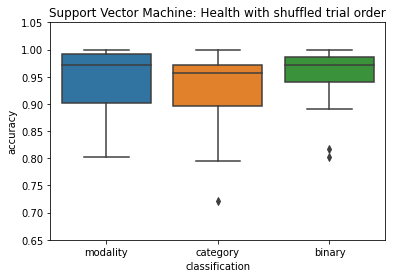

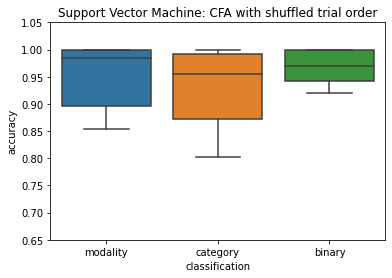

In [67]:
import seaborn as sns

health = svm_accuracy_shuff_row[svm_accuracy_shuff_row['session'].str.contains('Ses')]
cfa = svm_accuracy_shuff_row[svm_accuracy_shuff_row['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Support Vector Machine: Health with shuffled trial order')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'svm_health_shuff_row.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Support Vector Machine: CFA with shuffled trial order')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'svm_cfa_shuff_row.png'),bbox_inches='tight')
plt.show()

In [32]:
# TEST WHETHER SVM STILL DOES WELL IF TARGETS HAVE BEEN SHUFFLED IN TRAINING SET 
import ramdom
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    
    # Try a SVM on single session
    svm_category = np.array(cells['category'])
    svm_binary = np.array(cells['binary'])
    svm_modality = np.array(cells['modality'])
    svm_session = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    svm_session = np.array(svm_session)
    
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_modality, test_size=0.3,random_state=109) # 70% training and 30% test

    # shuffle order of training targets
    np.random.shuffle(y_train)
    
    # clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    # Train the model using the training sets
    clf.fit(X_train, y_train)
    
    # Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_category, test_size=0.3,random_state=109) # 70% training and 30% test

    # shuffle order of training targets
    np.random.shuffle(y_train)
    
    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    #Train the model using the training sets
    clf.fit(X_train, y_train)
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(svm_session, svm_binary, test_size=0.3,random_state=109) # 70% training and 30% test

    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC()

    # shuffle order of training targets
    np.random.shuffle(y_train)
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
cols = ['session', 'classification', 'accuracy']
svm_accuracy_shuff_targets = pd.DataFrame(accuracies, columns=cols)
svm_accuracy_shuff_targets.to_csv(os.path.join(output_path, 'svm_accuracies_shuff_targets.csv'))

processing:  dF_F0_SHORT_2P06_Ses01.csv
2P06_Ses01
Accuracy modality: 0.13138686131386862
Accuracy category: 0.44525547445255476
Accuracy binary: 0.6496350364963503
processing:  dF_F0_SHORT_2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 0.23484848484848486
Accuracy category: 0.30303030303030304
Accuracy binary: 0.6136363636363636
processing:  dF_F0_SHORT_2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 0.1349206349206349
Accuracy category: 0.1984126984126984
Accuracy binary: 0.6349206349206349
processing:  dF_F0_SHORT_2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.10218978102189781
Accuracy category: 0.32116788321167883
Accuracy binary: 0.5620437956204379
processing:  dF_F0_SHORT_2P06_Ses04.csv
2P06_Ses04
Accuracy modality: 0.08053691275167785
Accuracy category: 0.40268456375838924
Accuracy binary: 0.5704697986577181
processing:  dF_F0_SHORT_2P06_Ses05.csv
2P06_Ses05
Accuracy modality: 0.029197080291970802
Accuracy category: 0.43795620437956206
Accuracy binary: 0.5912408759124088
processing:

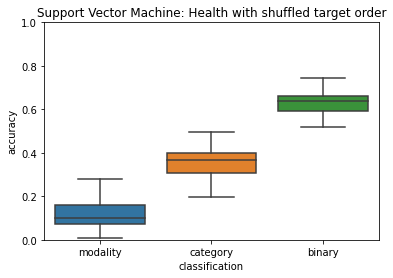

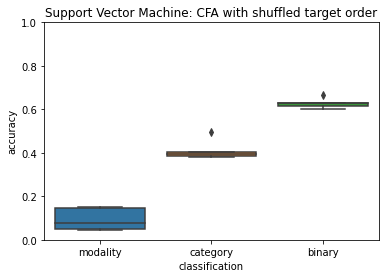

In [35]:
import seaborn as sns

health = svm_accuracy_shuff_targets[svm_accuracy_shuff_targets['session'].str.contains('Ses')]
cfa = svm_accuracy_shuff_targets[svm_accuracy_shuff_targets['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Support Vector Machine: Health with shuffled target order')
plt.ylim([0,1])
plt.savefig(os.path.join(output_path, 'svm_health_shuff_targets.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Support Vector Machine: CFA with shuffled target order')
plt.ylim([0,1])
plt.savefig(os.path.join(output_path, 'svm_cfa_shuff_targets.png'),bbox_inches='tight')
plt.show()

In [28]:
random.shuffle(y_list)
y_list

['warm',
 'no stim',
 'approach',
 'warm',
 'off-target',
 'hot',
 'approach',
 'hot',
 'no stim',
 'approach',
 'pin-prick',
 'off-target',
 'pin-prick',
 'approach',
 'pin-prick',
 'opto',
 'warm',
 'no stim',
 'von frey',
 'off-target',
 'pin-prick',
 'warm',
 'no stim',
 'warm',
 'off-target',
 'approach',
 'approach',
 'warm',
 'warm',
 'von frey',
 'approach',
 'von frey',
 'warm',
 'hot',
 'approach',
 'opto',
 'off-target',
 'pin-prick',
 'pin-prick',
 'no stim',
 'warm',
 'off-target',
 'pin-prick',
 'approach',
 'no stim',
 'warm',
 'hot',
 'pin-prick',
 'no stim',
 'no stim',
 'hot',
 'warm',
 'no stim',
 'hot',
 'pin-prick',
 'pin-prick',
 'no stim',
 'pin-prick',
 'approach',
 'off-target',
 'no stim',
 'warm',
 'pin-prick',
 'opto',
 'von frey',
 'no stim',
 'opto',
 'off-target',
 'approach',
 'off-target',
 'no stim',
 'no stim',
 'opto',
 'warm',
 'opto',
 'approach',
 'approach',
 'no stim',
 'von frey',
 'approach',
 'von frey',
 'opto',
 'pin-prick',
 'opto',
 'hot'

In [ ]:
# Attempt to use entire session as training set and predict other sessions for single mouse
session_names = []
accuracies = []

for mouse in [mice[0]]:
    for session in sessions:
        if session.startswith('._'): # circumventing issues with invisible files on external drives
            continue
        if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
            continue
        if session.endswith('2P05_Ses02.csv'):
            continue
        if session.endswith('2P07_Ses02.csv'):
            continue
        if session.endswith('2P11_Ses03.csv'):
            continue
        if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
            continue
        if mouse in session:
            
            print('processing: ', session)
            entries = session.split('_')
    
            if session.endswith('CFA.csv'): 
                ses_name = entries[3]+'_'+entries[4][:3]
        
            else:
                ses_name = entries[3]+'_'+entries[4][:5]
            
            print(ses_name)
            session_names.append(ses_name) 
        
        else:
            continue
    
    # assign 3rd session as training set
    cells = pd.read_csv(os.path.join(input_path,'dF_F0_SHORT_'+session_names[2]+'.csv'), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    y_train = np.array(cells['modality'])
    X_train = np.array(cells.drop(['identifier','modality'], axis=1))
    
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    
    # iterate through remaining sessions and test model
    session_names.remove(session_names[2])
    for s in session_names:
        cells = pd.read_csv(os.path.join(input_path,'dF_F0_SHORT_'+s+'.csv'), index_col=0)
        cell_ids = list(cells.columns)
    
        trials = cells['identifier'].unique()
    
        # Add 'modality' column
        conditions = [
        cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
        cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
        cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
        ]

        values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

        cells['modality'] = np.select(conditions, values)
        
        y_test = np.array(cells['modality'])
        X_test = np.array(cells.drop(['identifier','modality'], axis=1))
        
        #Predict the response for test dataset
        y_pred = clf.predict(X_test)

        print("Accuracy for "+s+": ",metrics.accuracy_score(y_test, y_pred))
        accuracies.append([s, metrics.accuracy_score(y_test, y_pred)])
  